$$
\textbf{Lógica Computacional: 2020/2021}\qquad
\textbf{Trabalho 1}\qquad
\scriptsize{Gilberto \, Cunha \quad Tomás \, Carneiro}
$$

# Problema 1

In [1]:
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from z3 import *

In [2]:
def all_simple_edges(G_in, source,target):
    paths = list(nx.all_simple_paths(G_in, source=source, target=target))
    edges = [[(paths[i][j-1], paths[i][j]) for j in range(1, len(paths[i]))] for i in range(len(paths))]
    return edges

Dado um grafo de input $G$ conectado, queremos determinar o seu subgrafo $\mathcal{H}$ com o mesmo número total de vértices $V$ tal que este continue a ser conectado e tenha o menor número de arestas possível.

Ambos $G$ e $\mathcal{H}$ podem ser representados por uma matriz de arestas $A$ e $B$, respetivamente, onde o elemento $A_{ij}, B_{ij} \in \{0, 1\}$ representam a existência de uma aresta orientada do vértice $n_i$ ao vértice $n_j$.

1. Para uma dada aresta pertencer a $\mathcal{H}$, então também deve pertencer a $G$:

$$ \forall_{\langle n_i, n_j \rangle \in G}, \quad 0 \le B_{ij} \le A_{ij} $$

Para cada par de vértices $\langle n_i, n_j \rangle \in G$ existe um conjunto de caminhos simples $S \equiv \{S_k\}$ que os liga. A função "all_simple_paths" da biblioteca "networkx" do python permite determinar este conjunto $S$. Para $\mathcal{H}$ ser fortemente ligado, então deve existir sempre pelo menos um caminho $S_k$ entre cada par.

Para um dado caminho $S_k$ existir, então:

$$\prod_{\langle n_w, n_z \rangle \in S_k} B_{w, z} = 1 $$

2. Podemos então que existe sempre um caminho entre todos os vértices de $\mathcal{H}$:

$$ \forall_{\langle n_i, n_j \rangle \in G} . n_i \neq n_j, \sum_{S_k \in S} \left( \prod_{\langle n_w, n_z \rangle \in S_k} B_{w, z} \right) \ge 1 $$

3. Devemos então minimizar o número de arestas em $\mathcal{H}$:

$$ minimize \sum_{i=0}^{V-1} \sum_{j=0}^{V-1} B_{ij} $$

## Gerar grafo $G$ aleatóriamente

In [3]:
# Gerar o grafo aleatóriamente
n = 32
k = np.random.randint(2, 5)
p = np.random.random()
G = nx.connected_watts_strogatz_graph(n, 2, p)

# Tornar o grafo orientado
G = G.to_directed()

## Definir as condições que permitem deduzir $\mathcal{H}$ no Z3

In [4]:
def strongly_connected_subgraph(G_in):
    solver = Optimize()
    B = {(i, j): Int(f'{i},{j}') for i in range(len(G_in.nodes())) for j in range(len(G_in.nodes()))}
    
    # Pertence ao grafo original
    for i in range(len(G_in.nodes())):
        for j in range(len(G_in.nodes())):
            if (i,j) in G_in.edges:
                A_ij = 1
            else:
                A_ij = 0
            solver.add(B[i,j]>=0, B[i,j]<=A_ij)

    # Condição de ser fortemente conectado
    for i in range(len(G_in.nodes())):
        for j in range(len(G_in.nodes())):
            if i != j:
                S = all_simple_edges(G_in, i, j)
                soma = Sum([Product([B[w,z] for (w,z) in S_k]) for S_k in S])
                solver.add(soma >= 1)

    # Minimizar o número de arestas
    obj = solver.minimize(Sum([B[i,j] for i in range(len(G_in.nodes())) for j in range(len(G_in.nodes()))]))

    # Verificar a satisfazibilidade
    if solver.check() == sat:
        print ("The model is satisfiable")
        print ("Is the minimum amount of edges an integer?", is_int_value(solver.lower(obj)))
        print ("The maximum number of removable edges is", len(G_in.edges) - int(str(solver.lower(obj))))
        m = solver.model()
    else:
        print ("The model is not satisfiable")
        m = None
        
    return m

## Determinar a solução $\mathcal{H}$

In [5]:
# Determinar solução H
H, m = nx.DiGraph(), strongly_connected_subgraph(G)
H.add_nodes_from([int(str(s).split(",")[0]) for s in m])
H.add_edges_from([(int(str(s).split(",")[0]), int(str(s).split(",")[1])) for s in m if m[s]==1])

The model is satisfiable
Is the minimum amount of edges an integer? True
The maximum number of removable edges is 12


In [6]:
# Verificar que não existe nenhuma aresta em H que não exista em G
count = sum([1 for edge in H.edges if edge not in G.edges])
if count >= 1:
    print ("There are edges in H that are not present in G")
else:
    print ("All edges in H are present in G")

All edges in H are present in G


In [7]:
# Verificar que G e H têm o mesmo número de nodos
if len(H.nodes) == len(G.nodes):
    print ("G and H have the same number of nodes")
else:
    print ("G and H do not have the same number of nodes")

G and H have the same number of nodes


## Dar plot ao grafo $G$ e das arestas removidas

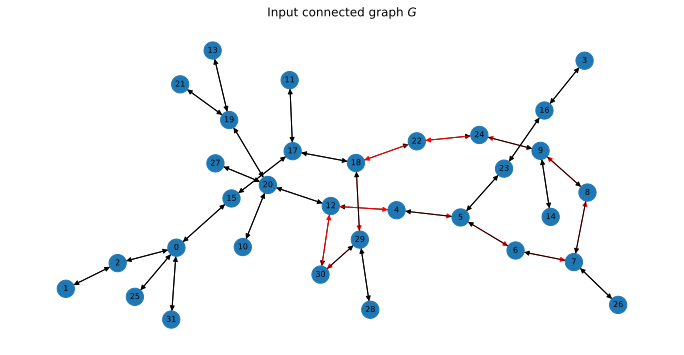

In [10]:
f = plt.figure(figsize=(12, 6))

# Pintar as arestas removidas a vermelho
edge_colors = []
for edge in G.edges:
    if edge not in H.edges:
        edge_colors.append("red")
    else:
        edge_colors.append("black")

# Plot do grafo de input
plt.title("Input connected graph $G$")
pos = nx.nx_pydot.graphviz_layout(G)
pos = nx.nx_pydot.graphviz_layout(G, prog="fdp")
nx.draw(G, font_size=8, pos=pos, with_labels=True, edge_color=edge_colors)
plt.show()

## Dar plot a um caminho entre um par aleatório $\langle n_i, n_j \rangle$

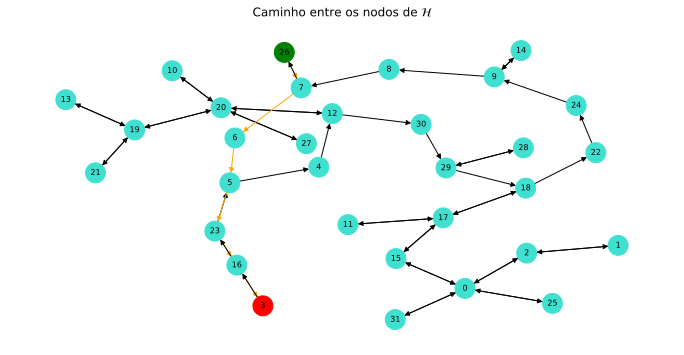

In [11]:
f = plt.figure(figsize=(12, 6))

# Gerar um par de nodos aleatóriamente
i, j = 0, 0
while i==j:
    i = np.random.randint(len(H.nodes))
    j = np.random.randint(len(H.nodes))

# Pintar as arestas desse caminho a laranja
path = all_simple_edges(H, i, j)[0]
edge_colors = []
for edge in H.edges:
    if edge in path:
        edge_colors.append("orange")
    else:
        edge_colors.append("black")
        
# Pintar o nodo inicial de verde e o nodo final de vermelho
node_colors = []
for node in H.nodes:
    if node == i:
        node_colors.append("green")
    elif node == j:
        node_colors.append("red")
    else:
        node_colors.append("turquoise")
        
# Plot do grafo de input
plt.title("Caminho entre os nodos de $\mathcal{H}$")
pos = nx.nx_pydot.graphviz_layout(H)
pos = nx.nx_pydot.graphviz_layout(H, prog="fdp")
nx.draw(H, font_size=8, node_size=4e2, pos=pos, with_labels=True, edge_color=edge_colors,
        node_color=node_colors)
plt.show()

Para um caminho $S_k$ existir, então:
$$\left \lceil \frac{1}{|S_k|} \sum_{\langle n_w, n_z \rangle \in S_k} A_{w, z} \right \rceil \ge 1 $$

Logo:
$$ \forall_{\langle n_i, n_j \rangle} . \langle n_i, n_j \rangle \in G, \sum_{S_k \in S} \left \lceil \frac{1}{|S_k|} \sum_{\langle n_w, n_z \rangle \in S_k} A_{w, z} \right \rceil \ge 1 $$